In [1]:
import torch
import torch.nn as nn
# from torchview import draw_graph
from einops import rearrange
from tqdm import tqdm
import torch.nn.functional  as Fn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from io import BytesIO
from IPython.display import Image as IPyImage, display
from PIL import Image
import matplotlib.pyplot as plt
import os
# from piq import ssim
import pandas as pd
from diffusers import AutoencoderDC
import gc
from torchvision import transforms
import wandb

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + 1e-10))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
        
    

In [4]:



class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
            
            nn.Conv2d(2 * hiddenDim, 4 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(4 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
            
            nn.Conv2d(4 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.Conv2d(embedDim, 4 * hiddenDim, 1),
            nn.ReLU(inplace=True),
        
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
            nn.Conv2d(4 * hiddenDim, 2 * hiddenDim, 3, padding=1),
            nn.ReLU(inplace=True),
        
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
            nn.Conv2d(2 * hiddenDim, hiddenDim, 3, padding=1),
            nn.ReLU(inplace=True),
        
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
            nn.Conv2d(hiddenDim, inChannels, 1),
        )

    
    def encoderBlock(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decoderBlock(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = x #self.encoderBlock(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decoderBlock(decoder_input)

        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss



In [5]:
DCAEEncoder = AutoencoderDC.from_pretrained(f"mit-han-lab/dc-ae-f64c128-in-1.0-diffusers", torch_dtype=torch.float32).to(device).eval()
datasetPath = "/Users/ishananand/Desktop/Tiny-Recursive-Model-for-Text-To-Image-Generation/"
data = pd.read_csv(datasetPath + "dataset/COCO2017.csv")


In [6]:
class ImageDataset(Dataset):
    def __init__(self, data, rootDir = ""):
        super().__init__()
        self.data = data
        self.rootDir = rootDir
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]

        image_path = os.path.join(self.rootDir, row['imagePath'])
        
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        # with torch.no_grad():
        #     latents = DCAEEncoder.encode(image).latent
        return image


# imgtxtdata = ImageDataset(data, rootDir=datasetPath)

# img = imgtxtdata.__getitem__(0)
# img.shape

BATCHSIZE = 48
CODEBOOKDIM = 2048
EMBEDDIM = 128
HIDDENDIM = 256
INPCHANNELS = 128
torchDataset = ImageDataset(data, rootDir=datasetPath)
dataloader = DataLoader(torchDataset, batch_size=BATCHSIZE, shuffle = True)
modelA = VecQVAE(inChannels = INPCHANNELS, hiddenDim = HIDDENDIM, codeBookdim = CODEBOOKDIM, embedDim = EMBEDDIM).to(device)
modelA = torch.nn.DataParallel(modelA)
modelA.to(device)
print(f"Total Parameters: {sum(p.numel() for p in modelA.parameters() if p.requires_grad)}")

# lossFn = nn.MSELoss()
optimizerA = torch.optim.Adam([
                    {'params': modelA.module.encoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.module.decoder.parameters(), 'lr': 2e-4},
                    {'params': modelA.module.vector_quantize.parameters(), 'lr': 1e-4}
                ], weight_decay=1e-5)
schedulerA = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizerA, T_0=10, T_mult=2, eta_min=1e-6
            )
epochs = 1000


start_epoch = 0
baseDir = os.getcwd()#os.path.dirname(__file__)
# baseDir = os.path.dirname(__file__)
checkpoint_path = os.path.join(baseDir, "models/vqvae", "vqvae.pt")
print(checkpoint_path)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    new_state_dict = {}
    for k, v in checkpoint['model_state_dict'].items():
        new_state_dict['module.' + k] = v  # add 'module.' prefix
    modelA.load_state_dict(new_state_dict)
    
    # modelA.load_state_dict(checkpoint['model_state_dict'])
    optimizerA.load_state_dict(checkpoint['optimizer_state_dict'])
    schedulerA.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    lowestVQVAELoss = checkpoint['lowestLoss']
    for state in optimizerA.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    print(f"Resuming from epoch {start_epoch} and lowest loss is {lowestVQVAELoss}")
else:
    lowestVQVAELoss = 2.53431
    print("Loading pretrained model...")


Total Parameters: 116606208
/Users/ishananand/Desktop/Hybrid-Architecture-T2I/models/vqvae/vqvae.pt
Resuming from epoch 7 and lowest loss is 10.874138958308427


torch.Size([3, 512, 512])


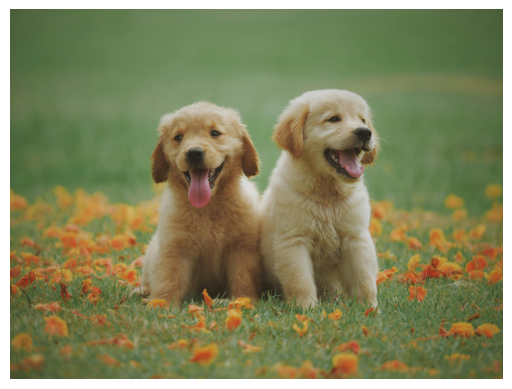

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()])

image = Image.open("/Users/ishananand/Desktop/Hybrid-Architecture-T2I/Images/testImage.jpg").convert("RGB")
plt.imshow(image)
plt.axis('off')
image = transform(image)
print(image.shape)

In [8]:
image = image.unsqueeze(0)
with torch.no_grad():
    X = DCAEEncoder.encode(image).latent
    X = X.to(device)
X.shape

torch.Size([1, 128, 8, 8])

In [9]:
modelA.eval()
modelA = modelA.to(device)
with torch.no_grad():
    quantized_latents, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss = modelA(X)
quantized_latents.shape#, decoderOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss

torch.Size([1, 128, 8, 8])

In [10]:
encoding_indices, encoding_indices.shape

# (tensor([ 567, 1032,  567, 1032,  567,  567, 1032,  567,  567, 1032, 1032, 1032,
#           539, 1876, 1032,  567, 1032, 1032, 1035, 1815, 1825, 1551, 1032, 1032,
#          1032, 1032, 1143, 1098, 1825, 1048, 1032, 1032,  267,  267,  214, 1513,
#           544, 1122,  267,  267, 1888,  197, 1728,  125,  178, 1122, 1070, 1888,
#          1377, 1818,  532,  197, 1928, 1377, 1818,  717,  267,  267,  267,  267,
#           267,  267,  267,  267]),
#  torch.Size([64]))

(tensor([1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032, 1032,
          539, 1876, 1032, 1032, 1032, 1032,  536, 1122, 1825, 1657, 1032, 1032,
         1032, 1032,  536, 1098, 1061,  400, 1032, 1032,  267,  267, 1211, 1513,
          137, 1122,  267,  267, 1888,  197,  906, 1513,  178, 1513, 1685,   42,
         1377, 1818, 1565, 1888, 1928, 1377, 1818,  717,  267,  267,  267,  267,
          267,  267,  267,  267]),
 torch.Size([64]))

In [11]:
with torch.no_grad():
    decoded = DCAEEncoder.decode(quantized_latents).sample
decoded.shape

torch.Size([1, 3, 512, 512])

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

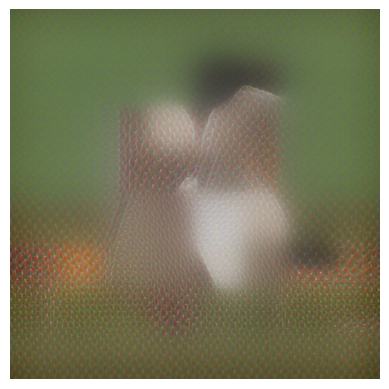

In [12]:
decoded = decoded.squeeze(0)
decoded = decoded.permute(1, 2, 0)
plt.imshow(decoded)
plt.axis('off')